## <span style="color:turquoise"> Exercise 09: Travelling Salesman Problem w/ Genetic Algorithms </span>

Travelling Salesman Problem:
- input: a stream of cities of knwon location, a cost function that evaluates the distance between a pair of cities
- desired: the path that touches all the cities only once, coming back to the start, with the lowest total cost on the path.

It is a NP-hard combinatorial problem, where the number of possible solutions grows factorially with the number of cities. So, a brute force solution would take, in the worst scenario, $O(n!)$ time. In this and the next exercise we will attack the problem with a genetic algorithm. 



Only selection operator: with the following conditions you get stuck in a non minima. with selection bias = 1.1 you get to the minima in few steps

Consider now the ordered sequence of cities, $\vec{c}_1, \vec{c}_2, \dots, \vec{c}_N$, which goes from city 1 to the $n^{th}$ city. The path that minimizes the following loss/cost function:

$$
L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|^2
$$

or 
$$
L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|
$$


(with $\vec{x}_{N+1}=\vec{x}_1$) is one particular permutation, P, of the ordered sequence of cities $\vec{c}_1, \vec{c}_2, \dots, \vec{c}_N$, i.e. 

$$
\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N = \vec{c}_{P1}, \vec{c}_{P2}, \dots, \vec{c}_{PN}
$$

We can express a possible path via a 1D vector whose elements, from the first to the last, are integers that represents the cities in the order in which the salesman would visit them; for example for $N=5$ cities one possible path is represented by the vector:

$$
\left[ 1, 3, 5, 4, 2 \right]
$$

To decrease degeneracy, we can fix the first city to be always the same. The only remaining degeneracy would be due to clockwise/anticlockwise travel.

In this exercise we developed a code to perform a genetic optimization, and then applied it to 34 fictious cities randomly put on a circumference and afterwards inside a square.

### <span style="color:turquoise"> 09.1: Code structure </span>

For the purpose we built a custom class

```cpp

class GeneticLab{

  public:
    // Default constructor, it sets up all the parameters at initialization
    GeneticLab(function<double(void)> randUnif,
               function<double(mat,rowvec)> fitnessFunction) : 
               _randUnif(randUnif),
               _fitnessFunction(fitnessFunction){ ; };

    // Destructor
    ~GeneticLab(){;};

.
.
.


  private:
    mat _pop;                                                       // all the chromosomes are collected in a matrix
    vec _fitnessLog;                                                // each entry is the fitness of a chromosome
    uvec _sortedIndicesFitness;                                     // indices of fitness log ordered by ascending fitness

    mat _data;                                                      // holds the data associated with the alleles
    rowvec _bestChromosome;                                         // holds the best chromosome
    double _bestFitness;                                            // stores the best fitness
    double _avHalfBestFitness;                                      // stores fitness average on the best half population


    function<double(mat,rowvec)> _fitnessFunction;                  // function to evaluate fitness. In this implementation lower is better
    function<double(void)> _randUnif;                               // Uniform random number generator to use across the algorithm

    int _Nalleles;                                                  // Number of alleles per chromosome
    int _popSize;                                                   // Size of the population
    double _selectionBias;                                          // Bias factor for selection
    int _elitism;                                                   // Number of elite chromosomes
    double _pcrossover;                                             // Crossover probability
    double _pmutation_pairPermutation;                              // Probability of pair permutation mutation
    double _pmutation_ClusterPermutation;                           // Probability of cluster permutation mutation
    double _pmutation_Shift;                                        // Probability of shift mutation
    double _pmutation_Inversion;                                    // Probability of inversion mutation
    int _Ngenerations;                                              // Number of generations in a run (Number of iterations)
};

- Among the private methods, set aside the useful parameters, GeneticLab stores a *population*, i.e. the collection of some chromosomes (in our case possible solutions). 
- The population will change at every step in the run, since we will implement several techniques (genetic algorithms GA) to increase the overall fitness, and in particular the best fitness: at the end of the run, the most fit chromosome will be our candidate solution. 
- We associate high fitness with low *cost function*: it is one of the two parameters necessary to build the class. In this case we will use the L(2) norm as fitness/cost function, because our GA is geared towards minimizing the input fitness/cost function. 
- Moreover, at each generation the fitness will be evaluated for each chromosome and stored in the *fitness log*, while the ordering of the chromosomes based on fitness will be saved in *sortedIndicesFitness*: this information in crucial for the GA.

Let us take a look at some important methods:

```cpp
void GeneticLab::SetupLab(){ 
    cout << "Setting up the lab..."<<endl;
    ReadParameters(); // Read simulation parameters
    ReadInput(); // Read location data of the cities
    GenerateStartingPop(); // Generate the initial population
    CheckPopulation(); // Check if the generated population meets requirements
    EvalFitness(); // Evaluate fitness for each chromosome
    OrderByFitness(); // Order the population by fitness
    SaveBest(); // Save the best fitness and chromosome
    cout << "Setup done."<<endl;
    cout << "Best Fitness is: "<< _bestFitness << endl;
    cout << "Best Global Fitness average on best half population is: "<< _avHalfBestFitness << endl;
    cout << "------------------------------"<<endl;
    cout << "------------------------------"<<endl<<endl;
};

- While setting up the lab we generate the starting population: it is done with a shuffle (Fisher-Yates) algorithm that keeps the first city unvaried. Then the population is checked: for a fast assessment of the validity of the solution, we just consider the sum of all the vector elements.

```cpp
// Function to generate the next generation of the population
void GeneticLab::NewGeneration(){
    // Create a new population matrix
    int rows = _popSize;
    int cols = _Nalleles;
    mat newPop(rows, cols, fill::zeros);

    // Elitism: save the best chromosomes
    for(int i=0; i<_elitism; i=i+2){
        uvec pair = SelectPair();
        newPop.row(i) = _pop.row(pair(0));
        newPop.row(i+1) = _pop.row(pair(1));
    }
    
    // For the remaining population, perform crossover, mutation
    for(int i=_elitism; i<_popSize; i=i+2){
        //selects a pair
        uvec pair = SelectPair();
        //copies in the new matrix
        newPop.row(i) = _pop.row(pair(0));
        newPop.row(i+1) = _pop.row(pair(1));

        /* straight copies to test mutations
        newPop.row(i) = _pop.row(i);
        newPop.row(i+1) = _pop.row(i+1);
        */

        //crossover on the pair
        if(_randUnif() < _pcrossover ) Crossover(newPop, i,i+1);

        //mutate on the singles
        if(_randUnif() < _pmutation_pairPermutation ) Mutate_PairPermutation(newPop, i);
        if(_randUnif() < _pmutation_ClusterPermutation ) Mutate_ClusterPermutation(newPop, i);
        if(_randUnif() < _pmutation_Shift ) Mutate_Shift(newPop, i);
        if(_randUnif() < _pmutation_Inversion ) Mutate_Inversion(newPop, i);

        if(_randUnif() < _pmutation_pairPermutation ) Mutate_PairPermutation(newPop, i+1);
        if(_randUnif() < _pmutation_ClusterPermutation ) Mutate_ClusterPermutation(newPop, i+1);
        if(_randUnif() < _pmutation_Shift ) Mutate_Shift(newPop, i+1);
        if(_randUnif() < _pmutation_Inversion ) Mutate_Inversion(newPop, i+1);
    }
        
    // Replace the old population with the new one
    _pop = newPop;    
}; 

How is a new generation brought to life? 
1) starting from the previous population
2) some (in number _elitism, user input) best* chromosomes are selected* and then kept the same and trasferred over
3) for the remaining ones (the great majority) a pair of best* chromosome is selected* and
4) undergoes crossover at a rate higher than 50% (user input). Crossover involves the pair together
5) undergoes mutations at a rate lower than 10% (user input). Mutations instead involve single chromosomes
6) the newly born chromosomes are saved in the new population

Through mutation the GA is able to explore the landscape of solutions (and maybe craft better ones, find deeper minima), while in crossover not only the former is true, but also the new born solutions could get the best of both chromosomes. Those two mechanisms provide "width" in the search.
The selection operation (that we noted with *, selection of best) instead provides depth and incentivizes the algorithm to improve on the best solutions generated at the moment of selection. Furthermore it propagates (together with elitism) the discoveries already made. Of course if the discoveries are good (the GA is near the desired minimum) then a strongly biased selection toward best solutions is helpful, but if we are close to a local minimum, strong selection bias could be very harmful.

With the ordered chromosomes, the a selection operator exploits the order in the population ($M$ individuals): selects the individual $j$ with $j= int(M \times r^p)+1$ where $r$ is a uniform random number $r\in[0,1)$ and $p$, the selection bias, a convenient exponent, for our purpose greater than 1.

let us expand on the crossover routine:

```cpp
// Crossover operation: Combines genetic information from two chromosomes
void GeneticLab::Crossover(mat& pop, unsigned int index1, unsigned int index2){
    // Select a crossover position 'pos'
    int pos = (int)(_randUnif()*(_Nalleles - 2) + 1);

    // Get chromosomes to perform crossover
    rowvec c1 = pop.row(index1);
    rowvec c2 = pop.row(index2);

    // Perform crossover by exchanging genetic information between chromosomes
    // based on the crossover position
    // Select matching elements between the two chromosomes and swap them
    uvec indices(_Nalleles-pos);
    for(int i=pos; i<_Nalleles;i++){
        double searchTarget = pop(index1,i);
        uvec searchResults = arma::find(pop.row(index2) == searchTarget);
        indices(i-pos) = searchResults(0);
    }
    uvec sortedIndicesCrossover1 = arma::sort_index(indices);

    for(int i=pos; i<_Nalleles;i++){
        double searchTarget = pop(index2,i);
        uvec searchResults = arma::find(pop.row(index1) == searchTarget);
        indices(i-pos) = searchResults(0);
    }
    uvec sortedIndicesCrossover2 = arma::sort_index(indices);

    
    // Perform the crossover operation
    for(int i=pos; i<_Nalleles;i++){

        pop(index1,i) = c1(pos+sortedIndicesCrossover1(i-pos));
    }

    for(int i=pos; i<_Nalleles;i++){
        pop(index2,i) = c2(pos+sortedIndicesCrossover2(i-pos));
    }


};

In practice, the two chromosomes are "cut" in a random spot, and then they are recombined using the order of the missing cities of the other chromosome.

Lastly, concerning the mutations, we implemented 4 different schemes:

- Mutate_PairPermutation: Mutation operator that permutes a random pair of alleles 
- Mutate_ClusterPermutation: Mutation operator that permutes two clusters of alleles of random length
- Mutate_Shift: Mutation operator that shifts randomly a cluster of random length 
- Mutate_Inversion: Mutation operator that inverts the order of the alleles in a random sequence 

### <span style="color:turquoise"> 09.1: Application </span>

We apply our algorithm to 34 cities in a circle to test it. 
Parameters used are: \
Nalleles = 34 \
popSize = 1000 \
selectionBias = 1.3 \
elitism = 0 \
pcrossover = 0.5 \
pmutation_pairPermutation = 0.08 \
pmutation_ClusterPermutation = 0.08 \
pmutation_Shift = 0.08 \
pmutation_Inversion = 0.08 \
Ngenerations = 10000 

In [1]:
#import essential libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#parameter to use Latex in matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#a plot label should be easy to read
plt.rcParams.update({'font.size': 14})

In [2]:
def importDataTSP(path):
    fitness = np.loadtxt(path+'/out_fitness.txt', skiprows=1)
    TSpath = np.loadtxt(path+'/out_path.txt')
    locCities = np.loadtxt(path+'/input.in')
    return fitness, TSpath.astype(int), locCities

In [36]:
fitness, TSpath, locCities = importDataTSP("./circle_results")

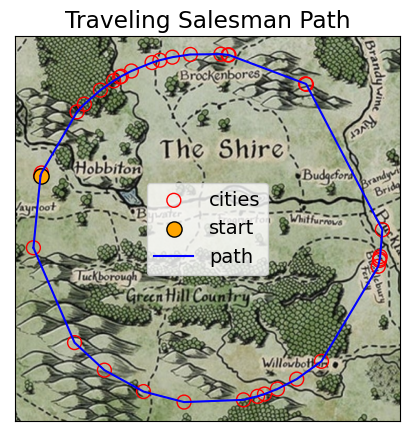

In [37]:
# Load your image
import matplotlib.image as mpimg
img = mpimg.imread('TSP_shire.png')



fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# Display the image as the background
ax.imshow(img, extent=[-1.1, 1.1, -1.1, 1.1])
scatter = ax.scatter(locCities[:,0], locCities[:,1], marker="o",edgecolor='red', facecolor='none', s=100)
ax.scatter(locCities[:,0][TSpath[0]], locCities[:,1][TSpath[0]], marker="o",edgecolor='black', facecolor='orange', s=120)
ax.plot(locCities[:,0][TSpath], locCities[:,1][TSpath], c="blue", alpha=1, label='Progressive optimization')
ax.plot([locCities[:,0][TSpath[-1]],locCities[:,0][TSpath[0]]], [locCities[:,1][TSpath[-1]],locCities[:,1][TSpath[0]]], c="blue", alpha=1, label='Progressive optimization')

# Adding title and deactivating ticks on the axes
ax.set_title('Traveling Salesman Path')
ax.set_xticks([])  # Deactivate ticks on x-axis
ax.set_yticks([])  # Deactivate ticks on y-axis

ax.legend(["cities", "start", "path"])

Text(0.5, 0, 'generation')

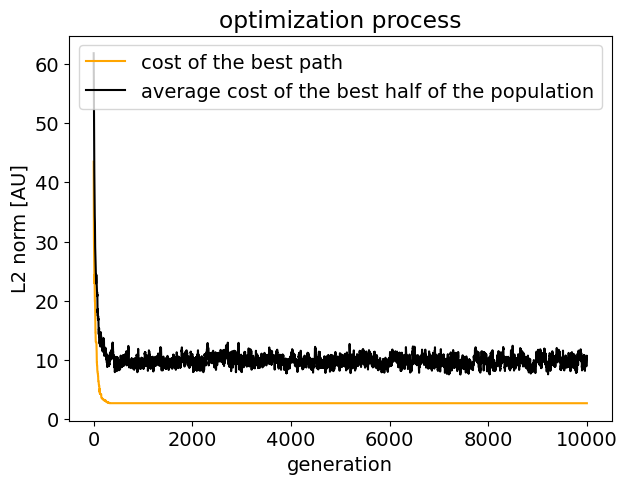

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(range(10001), fitness[:,0], c="orange")
ax.plot(range(10001), fitness[:,1], c="black")

ax.legend(["cost of the best path", "average cost of the best half of the population"])
ax.set_title("optimization process")
ax.set_ylabel("L2 norm [AU]")
ax.set_xlabel("generation")

We apply our algorithm also to 34 cities inside a square. 
Parameters used are: \
Nalleles = 34 \
popSize = 1000 \
selectionBias = 1.3 \
elitism = 0 \
pcrossover = 0.5 \
pmutation_pairPermutation = 0.08 \
pmutation_ClusterPermutation = 0.08 \
pmutation_Shift = 0.08 \
pmutation_Inversion = 0.08 \
Ngenerations = 1000 

In [65]:
fitness, TSpath, locCities = importDataTSP("./square_results")

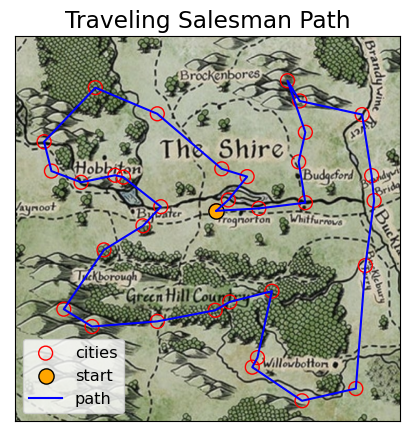

In [66]:
# Load your image
import matplotlib.image as mpimg
img = mpimg.imread('TSP_shire.png')



fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# Display the image as the background
ax.imshow(img, extent=[-1.1, 1.1, -1.1, 1.1])
scatter = ax.scatter(locCities[:,0], locCities[:,1], marker="o",edgecolor='red', facecolor='none', s=100)
ax.scatter(locCities[:,0][TSpath[0]], locCities[:,1][TSpath[0]], marker="o",edgecolor='black', facecolor='orange', s=120)
ax.plot(locCities[:,0][TSpath], locCities[:,1][TSpath], c="blue", alpha=1, label='Progressive optimization')
ax.plot([locCities[:,0][TSpath[-1]],locCities[:,0][TSpath[0]]], [locCities[:,1][TSpath[-1]],locCities[:,1][TSpath[0]]], c="blue", alpha=1, label='Progressive optimization')

# Adding title and deactivating ticks on the axes
ax.set_title('Traveling Salesman Path')
ax.set_xticks([])  # Deactivate ticks on x-axis
ax.set_yticks([])  # Deactivate ticks on y-axis

ax.legend(["cities", "start", "path"], fontsize='small', loc="best")

Text(0.5, 0, 'generation')

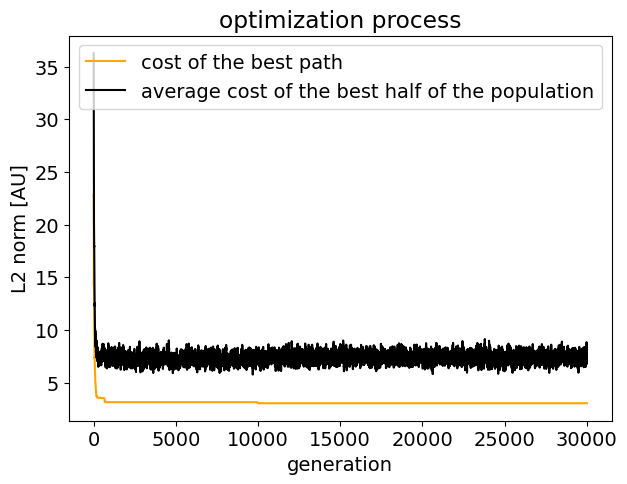

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(range(30001), fitness[:,0], c="orange")
ax.plot(range(30001), fitness[:,1], c="black")

ax.legend(["cost of the best path", "average cost of the best half of the population"])
ax.set_title("optimization process")
ax.set_ylabel("L2 norm [AU]")
ax.set_xlabel("generation")

To see whether we reached a local minimum or the actual global minimum, we performed the GA search with different seeds, and we found that the algorithm tends to be stuck in those among the first 15000 generations.